#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# установка модуля phik
!pip install phik -q

In [2]:
import phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

## Подготовка

### Загрузка данных

In [3]:
#считывание csv-файла и сохранение в датафрейм
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
taxi.sort_index(inplace=True)

In [5]:
# получение первых 10 строк датафрейма taxi
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
# вывод основной информации о датафрейме taxi
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# проверка хрологического порядка расположения индексов
taxi.index.is_monotonic

True

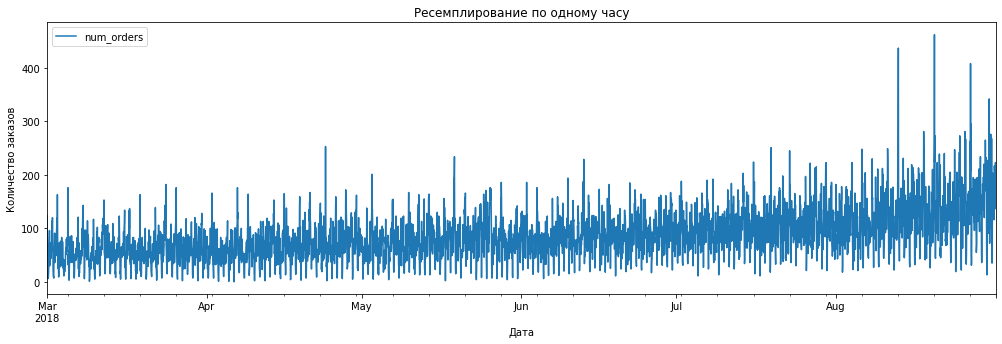

In [8]:
# ресемплирование по одному часу
taxi = taxi.resample('1H').sum()
taxi.plot(figsize=(17, 5))
plt.title('Ресемплирование по одному часу')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

**Вывод по результатам подготовки данных:**\
В результате подготовки данных был загружен датафрейм taxi, проведена проверка хронологического порядка индексов, а также выполнено ресемплирование по одному часу с вычислением суммы количества заказов за каждый час.\
По данным графика можно сказать, что количество заказов в час в августе 2018 года увеличилось.

## Анализ

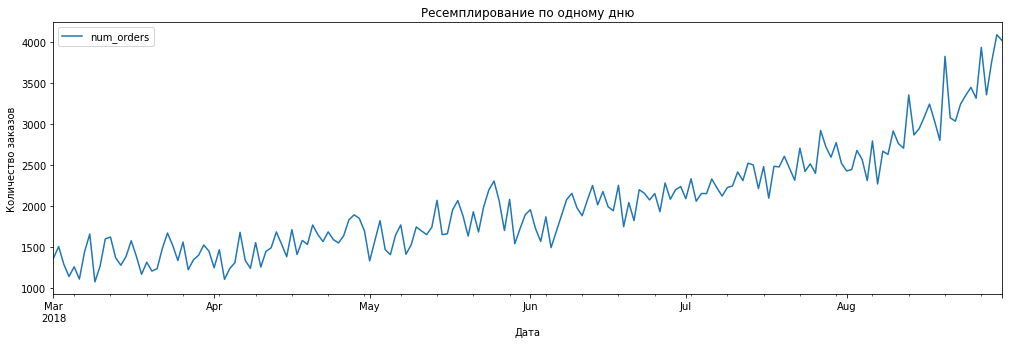

In [9]:
# ресемплирование по одному дню
taxi_day = taxi.resample('1D').sum()
taxi_day.plot(figsize=(17, 5))
plt.title('Ресемплирование по одному дню')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

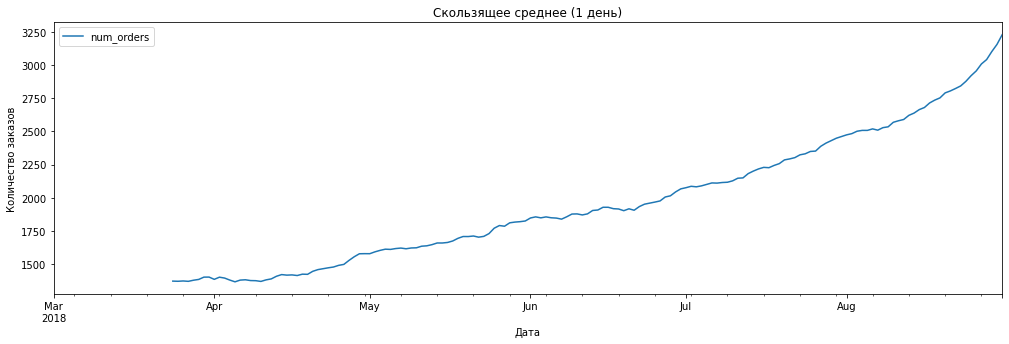

In [10]:
# cкользящее среднее при ресемплировании по одному дню
rolling_day = taxi_day.rolling(24).mean()
rolling_day.plot(figsize=(17, 5))
plt.title('Скользящее среднее (1 день)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

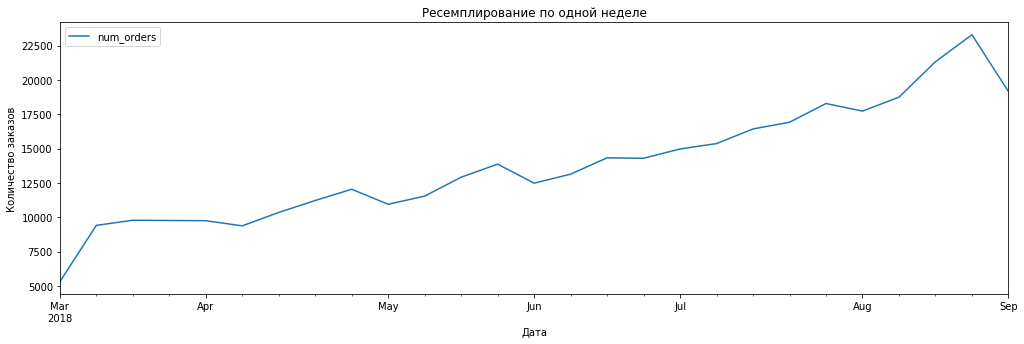

In [11]:
# ресемплирование по одной неделе
taxi_week = taxi.resample('1W').sum()
taxi_week.plot(figsize=(17, 5))
plt.title('Ресемплирование по одной неделе')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

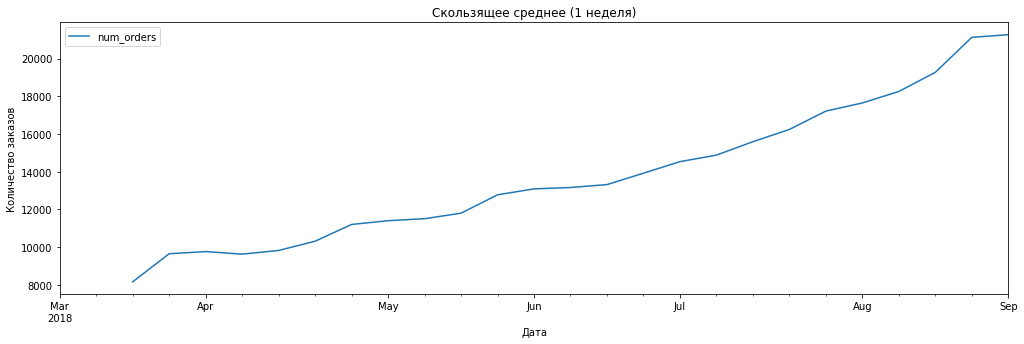

In [12]:
# cкользящее среднее при ресемплировании по одной неделе
rolling_week = taxi_week.rolling(3).mean()
rolling_week.plot(figsize=(17, 5))
plt.title('Скользящее среднее (1 неделя)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов');

По полученным графикам ресемплирования и скользящих средних по одному дню и одной неделе  можно сказать, что суммарное количество заказов увеличивалось со временем.

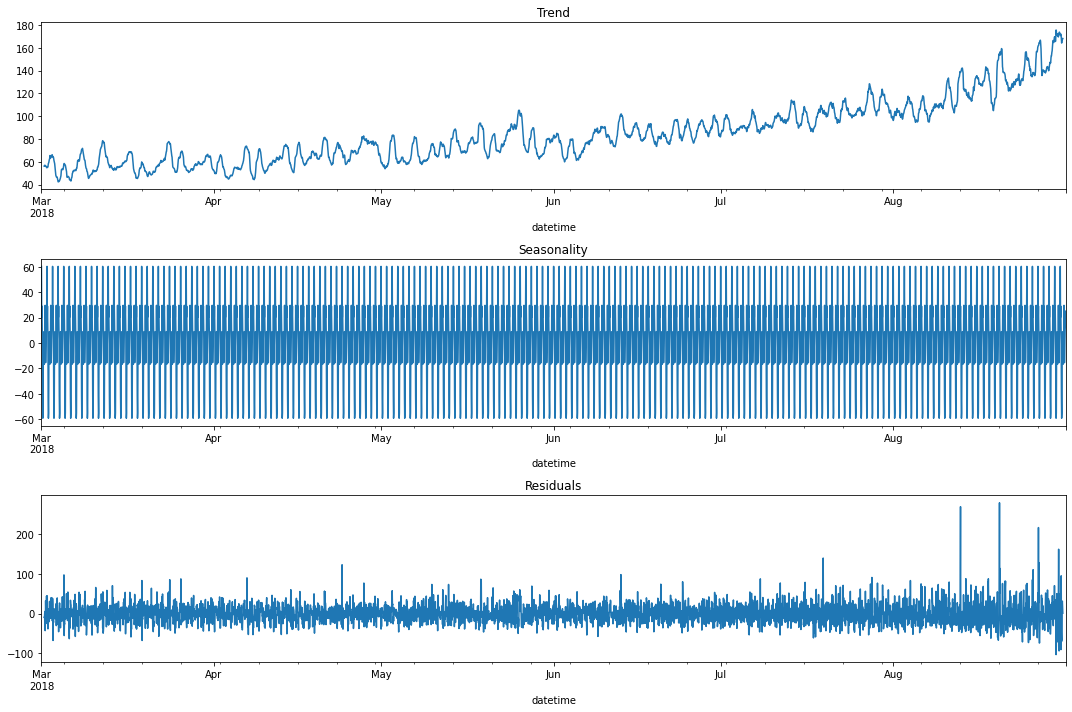

In [13]:
# разложение временного ряда на тренд, сезонную компоненту и остаток декомпозиции
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(15, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

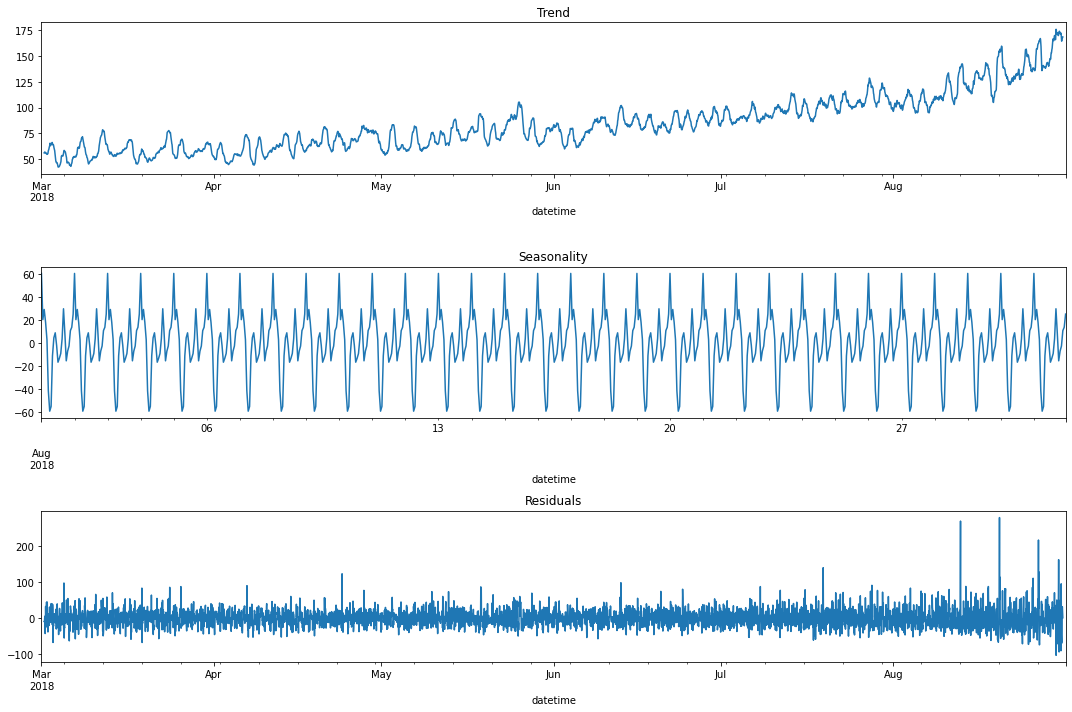

In [14]:
# разложение временного ряда на тренд, сезонную компоненту и остаток декомпозиции
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(15, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal['2018-08-01': '2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод по результатам анализа:**\
По полученным графикам для всего времени стоит отметить тренд на увеличение количества заказов, а по графику сезонности за неделю в августе можно сделать вывод, что сезонность составляет одни сутки. Также стоит отметить, что самое большое количество заказов приходится на поздний вечер дня.

## Обучение

In [15]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42

In [16]:
# функция с созданием признаков 
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(taxi, 168, 168)

In [18]:
# разделение на тренировочную и тестовую выборки 
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

In [19]:
# обучение модели DecisionTreeRegressor
param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}
dtree_reg = DecisionTreeRegressor(random_state=42)
tscv_dtr = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=dtree_reg, 
                           param_grid=param_grid, 
                           cv=tscv_dtr, 
                           n_jobs=-1, 
                           verbose=2, 
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
best_score_tree = grid_search.best_score_
print(f"best_score: {-best_score_tree}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END max_depth=10,

In [20]:
# задание гиперпараметров для модели LGBMRegressor
param_grid = {
    'num_leaves': [20, 31],
    'learning_rate': [0.05, 0.1]
}

# инициализация модели LGBMRegressor
model = lgb.LGBMRegressor()

# обучение модели LGBMRegressor
tscv_LGBM = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error', 
                           cv=tscv_LGBM)

grid_search.fit(X_train, y_train)
best_score_LGBM = grid_search.best_score_
print(f"Best_score: {-best_score_LGBM}")

Best_score: 22.83822831943362


**Вывод по результатам обучения:**\
Для обучения были выбраны две модели: DecisionTreeRegressor и LGBMRegressor. У каждой модели были различные гиперпараметры и в результате обучения значение метрики RMSE для модели DecisionTreeRegressor равняется 31.5, для LGBMRegressor - 22.8. Обе модели выполнили критерий по значению метрики менее 48, но меньшее значение показала модель LGBMRegressor, поэтому именно она выбрана для тестирования.

## Тестирование

In [21]:
best_model_LGBM = grid_search.best_estimator_
y_pred = best_model_LGBM.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 36.54923109533388


## Общий вывод

Были загружены данные из датасета taxi и проведено ресемплирование по одному часу с вычислением суммы количества заказов за каждый час. По полученным графикам ресемплирования и скользящих средних по одному дню и одной неделе было выявлено, что суммарное количество заказов увеличивалось со временем. После была проведена декомпозиция данных, в результате которой было выявлена суточная сезонность. По результатам декомпозиции можно сказать, что количество заказов увеличивалось к концу недели и уменьшалась в первые дни недели. Также стоит отметить, что самое большое количество заказов приходится на поздний вечер дня. В датасет taxi были добавлены новые признаки по результатам декомпозиции.  Далее были обучены две модели: DecisionTreeRegressor и LGBMRegressor. У каждой модели были различные гиперпараметры и в результате обучения значение метрики RMSE для модели DecisionTreeRegressor равняется 31.5, для LGBMRegressor - 22.8. По значению метрики RMSE для тестирования была выбрана модель LGBMRegressor. По результатам тестирования мы получили значение метрики RMSE равное 36.5. 